In [ ]:
t = threading.Thread(target=start_gui, name=gui_name,
                 args=(window, gui_name, *args),
                 kwargs={'use_thread': False, **kwargs})

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


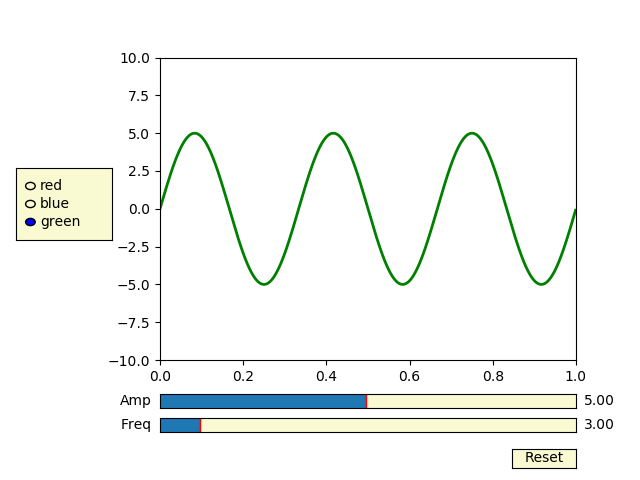

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()

In [9]:
from time import sleep

import threading

class MyThread(threading.Thread):

    def __init__(self, *args, **kwargs):
        # Flag that exits loop when set to True
        self._stop = False
        super().__init__(*args, **kwargs)
    
    def start(self):
        # Flag that allows actions to be performed in loop
        self._is_active = True
        try:
            super().start()
        except RuntimeError:
            # Thread already started, ignoring
            pass
    
    def run(self):
        while not self._stop:
            if self._is_active:
                print('is running')
            sleep(1)
    
    def stop(self):
        self._is_active = False

    def exit(self):
        self._stop = True
        
t = MyThread()

is running
is running


In [ ]:
import os
import tempfile
from functools import partial
from time import sleep
import inspect
from slacker import Slacker
from silq.tools.general_tools import Singleton

from qcodes.plots.base import BasePlot
from qcodes.data.data_set import DataSet
from qcodes import config as qc_config
from qcodes.instrument.parameter import Parameter
def convert_command(text):
    def try_convert_str(string):
        try:
            val = int(string)
            return val
        except:
            pass
        try:
            val = float(string)
            return val
        except:
            pass

        return string


    # Format text to lowercase, and remove trailing whitespaces
    text = text.lower().rstrip(' ')
    command, *args_str = text.split(' ')

    # Convert string args to floats/kwargs
    args = []
    kwargs = {}
    for arg in args_str:
        if '=' in arg:
            # arg is a kwarg
            key, val = arg.split('=')
            # Try to convert into a float
            val = try_convert_str(val)
            kwargs[key] = val
        else:
            # arg is not a kwarg
            # Try to convert into a float
            val = try_convert_str(arg)
            args.append(val)
    return command, args, kwargs


class Slack():
    """
    Slack bot used to send information about qcodes via Slack IMs.
    Some default commands are provided, and custom commands/tasks can be
    attached (see below).

    To setup the Slack bot, a bot first has to be registered via Slack
    by clicking 'creating a new bot user' on https://api.slack.com/bot-users.
    Once registered, the bot will have a name and unique token.
    These and other settings have to be saved in a config dict (see init).

    Communication with the Slack bot is performed via instant messaging.
    When an IM is sent to the Slack bot, it will be processed during the next
    `update()` call (provided the username is registered in the config).
    Standard commands provided to the Slack bot are:
        plot: Upload latest qcodes plot
        msmt/measurement: Print information about latest measurement
        notify finished: Send message once measurement is finished

    Custom commands can be added as (cmd, func) key-value pairs to
    `self.commands`. When `cmd` is sent to the bot, `func` is evaluated.

    Custom tasks can be added as well. These are functions that are performed
    every time an update is called. The function must return a boolean that
    indicates if the task should be removed from the list of tasks.
    A custom task can be added as a (cmd, func) key-value pair  to
    `self.task_commands`.
    They can then be called through Slack IM via
        notify/task {cmd} *args: register task with name `cmd` that is
            performed every time `update()` is called.
    """
    def __init__(self, interval=5, config=None, auto_start=False,
                 **commands):
        """
        Initializes Slack bot, including auto-updating widget if in notebook
        and using multiprocessing.
        Args:
            interval (int): Update interval for widget (must be over 1s).
            config (dict, optional): Config dict
                If not given, uses qc.config['user']['slack']
                The config dict must contain the following keys:
                    'bot_name': Name of the bot
                    'bot_token': Token from bot (obtained from slack website)
                    'names': Usernames to periodically check for IM messages

        """
        if config is not None:
            self.config = config
        else:
            self.config = qc_config.user.slack

        self.slack = Slacker(self.config['token'])
        self.bot_id = self.slack.users.get_user_id(self.config['bot_name'])
        self.users = self.get_users(self.config['names'])
        self.get_im_ids(self.users)

        self.commands = {'plot': self.upload_latest_plot,
                         'msmt': self.print_measurement_information,
                         'measurement': self.print_measurement_information,
                         'notify': self.add_task,
                         'task': self.add_task,
                         **commands}
        self.task_commands = {'finished': self.check_msmt_finished}

        self.interval = interval
        self.tasks = []

        if auto_start:
            self.start()

    def start(self):
        while True:
            # Repeatedly check for updates
            self.update()
            sleep(self.interval)

    def user_from_id(self, user_id):
        """
        Retrieve user from user id.
        Args:
            user_id: Id from which to retrieve user information

        Returns:
            user (dict): user information
        """
        users = [user for user in self.users if
                 self.users[user]['id'] == user_id]
        assert len(users) == 1, "Could not find unique user with id {}".format(
            user_id)
        return users[0]

    def get_users(self, usernames):
        """
        Extracts user information for users
        Args:
            usernames: Slack usernames of users

        Returns:
            users (dict): {username: user}
        """
        users = {}
        response = self.slack.users.list()
        for member in response.body['members']:
            if member['name'] in usernames:
                users[member['name']] = member
        if len(users) != len(usernames):
            remaining_names = [name for name in usernames if name not in users]
            raise RuntimeError(
                'Could not find names {}'.format(remaining_names))
        return users

    def get_im_ids(self, users):
        """
        Adds IM ids of users to users dict.
        Also adds last_ts to the latest IM message
        Args:
            users (dict): {username: user}

        Returns:
            None
        """
        response = self.slack.im.list()
        user_ids = {user: users[user]['id'] for user in users}
        im_ids = {im['user']: im['id'] for im in response.body['ims']}
        for username, user_id in user_ids.items():
            if user_id in im_ids:
                users[username]['im_id'] = im_ids[user_id]
                # update last ts
                users[username]['last_ts'] = float(
                    self.get_im_messages(username=username, count=1)[0]['ts'])

    def get_im_messages(self, username, **kwargs):
        """
        Retrieves IM messages from username
        Args:
            username: Name of user
            **kwargs: Additional kwargs for retrieving IM messages

        Returns:
            List of IM messages
        """
        response = self.slack.im.history(channel=self.users[username]['im_id'],
                                         **kwargs)
        return response.body['messages']

    def get_new_im_messages(self):
        """
        Retrieves new IM messages for each user in self.users.
        Updates user['last_ts'] to ts of newest message
        Returns:
            im_messages (Dict): {username: [messages list]} newer than last_ts
        """
        im_messages = {}
        for username, user in self.users.items():
            last_ts = user.get('last_ts', None)
            new_messages = self.get_im_messages(username=username,
                                                oldest=last_ts)
            # Kwarg 'oldest' sometimes also returns message with ts==last_ts
            new_messages = [m for m in new_messages if
                            float(m['ts']) != last_ts]
            im_messages[username] = new_messages
            if new_messages:
                self.users[username]['last_ts'] = float(new_messages[0]['ts'])
        return im_messages

    def update(self):
        """
        Performs tasks, and checks for new messages.
        Periodically called from widget update.
        Returns:
            None
        """
        new_tasks = []
        for task in self.tasks:
            task_finished = task()
            if not task_finished:
                new_tasks.append(task)
        self.tasks = new_tasks

        new_messages = self.get_new_im_messages()
        self.handle_messages(new_messages)

    def handle_messages(self, messages):
        """
        Performs commands depending on messages.
        This includes adding tasks to be performed during each update.
        """
        for user, user_messages in messages.items():
            for message in user_messages:
                if message.get('user', None) != self.users[user]['id']:
                    # Filter out bot messages
                    continue
                channel = self.users[user]['im_id']
                # Extract command (first word) and possible args
                command, args, kwargs = convert_command(message['text'])
                if command in self.commands:
                    msg = 'Executing {}'.format(command)
                    if args:
                        msg += ' {}'.format(args)
                    if kwargs:
                        msg += ' {}'.format(kwargs)
                    self.slack.chat.post_message(text=msg, channel=channel)

                    func = self.commands[command]
                    if isinstance(func, Parameter):
                        func(*args, **kwargs)
                    else:
                        # Only add channel and Slack if they are explicit kwargs
                        func_sig = inspect.signature(func)
                        if 'channel' in func_sig.parameters:
                            kwargs['channel'] = channel
                        if 'slack' in func_sig.parameters:
                            kwargs['slack'] = self
                        func(*args, **kwargs)
                else:
                    self.slack.chat.post_message(
                        text='Command {} not understood'.format(command),
                        channel=channel)

    def add_task(self, command, *args, channel, **kwargs):
        """
        Add a task to self.tasks, which will be executed during each update
        Args:
            command: task command
            *args: Additional args for command
            channel: Slack channel (can also be IM channel)
            **kwargs: Additional kwargs for particular

        Returns:
            None
        """
        if command in self.task_commands:
            self.slack.chat.post_message(
                text='Added task "{}"'.format(command),
                channel=channel)
            func = self.task_commands[command]
            self.tasks.append(partial(func, *args, channel=channel, **kwargs))
        else:
            self.slack.chat.post_message(
                text='Task command {} not understood'.format(command),
                channel=channel)

    def upload_latest_plot(self, channel, **kwargs):
        """
        Uploads latest plot (if any) to slack channel.
        The latest plot is retrieved from BasePlot, which is updated every
        time a new qcodes plot is instantiated.
        Args:
            channel: Slack channel (can also be IM channel)
            **kwargs: Not used

        Returns:
            None
        """
        # Create temporary filename
        temp_filename = tempfile.mktemp(suffix='.jpg')
        # Retrieve latest plot
        latest_plot = BasePlot.latest_plot
        if latest_plot is not None:
            # Saves latest plot to filename
            latest_plot.save(filename=temp_filename)
            # Upload plot to slack
            self.slack.files.upload(temp_filename, channels=channel)
            os.remove(temp_filename)
        else:
            self.slack.chat.post_message(text='No latest plot',
                                         channel=channel)

    def print_measurement_information(self, channel, **kwargs):
        """
        Prints information about the current measurement.
        Information printed is percentage complete, and dataset representation.
        Dataset is retrieved from DataSet.latest_dataset, which updates itself
        every time a new dataset is created
        Args:
            channel: Slack channel (can also be IM channel)
            **kwargs: Not used

        Returns:
            None
        """
        dataset = DataSet.latest_dataset
        if dataset is not None:
            dataset.sync()
            self.slack.chat.post_message(
                text='Measurement is {:.0f}% complete'.format(
                    100 * dataset.fraction_complete()),
                channel=channel)
            self.slack.chat.post_message(
                text=repr(dataset), channel=channel)
        else:
            self.slack.chat.post_message(
                text='No latest dataset found',
                channel=channel)

    def check_msmt_finished(self, channel, **kwargs):
        """
        Checks if the latest measurement is completed.
        Args:
            channel: Slack channel (can also be IM channel)
            **kwargs: Not used

        Returns:
            is_finished (Bool): True if measurement is finished, False otherwise
        """
        dataset = DataSet.latest_dataset
        if dataset is None:
            self.slack.chat.post_message(
                text='No latest dataset found',
                channel=channel)
            return True

        if dataset.sync():
            # Measurement is still running
            return False

        self.slack.chat.post_message(
            text='Measurement complete\n' + repr(dataset),
            channel=channel)
        return True
